In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

random_state = 42
np.random.seed(random_state)

In [2]:
# read the dataset
df = pd.read_csv('data/training_data.csv')
df

,timestamp,relation,train_number,delay,delay_cause
0,1667667583683,Szentendre - Batthyány tér,36H4001,0.740741,NaN
1,1667668572716,Batthyány tér - Szentendre,36H4008,0.095238,NaN
2,1667668696292,Szentendre - Batthyány tér,36H4011,0.444444,NaN
3,1667667830983,Batthyány tér - Szentendre,36H4012,3.000000,NaN
4,1667669806292,Batthyány tér - Szentendre,36H4018,0.333333,NaN
...,...,...,...,...,...
122119,1671354288630,Kecskemét - Budapest-Nyugati,552915,2.468354,Pálya állapota miatti késés
122120,1671035615214,Kőszeg - Szombathely,4339953,2.647059,NaN
122121,1671122465324,Kőszeg - Szombathely,4339953,3.714286,NaN
122122,1671208362253,Kőszeg - Szombathely,4339953,2.692308,NaN


In [3]:
# drop the delay column
df = df.drop(columns=['delay'])

# transform timestamp to hour
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x / 1000).hour)

# encode the non-numberic values
df['relation'] = df['relation'].apply(hash)
df['train_number'] = df['train_number'].apply(hash)
df['delay_cause'] = np.where(df['delay_cause'].isna(), 'no delay', df['delay_cause'])
categories = pd.Categorical(df['delay_cause'])
df['delay_cause'] = categories.codes

df

,timestamp,relation,train_number,delay_cause
0,17,-2974205048464794897,-4627051195886462710,19
1,18,7573219263469716877,453036880862259486,19
2,18,-2974205048464794897,-7219624175823998645,19
3,18,7573219263469716877,-1113834336422817780,19
4,18,7573219263469716877,6115416708326256527,19
...,...,...,...,...
122119,10,-2082236081582631203,5260785830624008658,10
122120,17,7214299802862426315,8002196796149959632,19
122121,17,7214299802862426315,8002196796149959632,19
122122,17,7214299802862426315,8002196796149959632,19


In [4]:
pd.Categorical(df['delay_cause']).categories

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')

In [5]:
# split the dataset into 80% training and 10% test 10% validation set
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['delay_cause']), df.delay_cause, test_size=0.2, random_state=random_state)
#X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=random_state)

# normalize the values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#X_valid = scaler.transform(X_valid)
# the dataset is imbalanced, therefore we oversample to try to correct this
values, counts = np.unique(Y_train, return_counts=True)
print(pd.DataFrame({'values':values, 'counts':counts}))
ros = RandomOverSampler()
X_train, Y_train = ros.fit_resample(X_train, Y_train)
values, counts = np.unique(Y_train, return_counts=True)
print(pd.DataFrame({'values':values, 'counts':counts}))

    values  counts
0        0     253
1        1     960
2        2    1184
3        3     132
4        4      88
5        5      89
6        6      71
7        7     603
8        8       4
9        9       6
10      10    7942
11      11     119
12      12      87
13      13    2307
14      14       2
15      15     158
16      16    6041
17      17      17
18      18     141
19      19   77495
    values  counts
0        0   77495
1        1   77495
2        2   77495
3        3   77495
4        4   77495
5        5   77495
6        6   77495
7        7   77495
8        8   77495
9        9   77495
10      10   77495
11      11   77495
12      12   77495
13      13   77495
14      14   77495
15      15   77495
16      16   77495
17      17   77495
18      18   77495
19      19   77495


In [6]:
# create a random forest classifier model
model = RandomForestClassifier(n_estimators=10, verbose=2, random_state=random_state, n_jobs=10)

# train the model
history = model.fit(X_train, Y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    7.6s remaining:   17.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    8.0s finished


In [7]:
# score the model between 0.0 and 1.0
score = model.score(X_test, Y_test)
score

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


0.5046878198567042

In [8]:
# predict delay casuses using the trained model
predictions = history.predict(X_test)

rownames = categories.from_codes(predictions, categories=categories.categories)
colnames = categories.from_codes(Y_test, categories=categories.categories)
# create confusion matrix from true and predicted labels
conf = pd.crosstab(colnames, rownames, margins=True, normalize='index',)
# conf = conf.apply(lambda column: column / column.iloc[len(column)-1], axis=1)

# drop the margin
#conf = conf.drop(columns=['All'])
conf = conf.drop(conf.tail(1).index)

# show the confusion matrix
conf

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


col_0,Baleset miatti késés,Biztosítóberendezési hiba miatti késés,Csatlakozásra várás miatti késés,Felsővezetéki hiba miatti késés,Forgalmi ok miatti késés,Hatósági intézkedés miatti késés,Időjárási ok miatti késés,Más vonat által okozott késés,Más vonattól átvett késés,Műszaki ok miatti késés vonatnál,Pálya állapota miatti késés,Pályaépítés miatti késés,Rongálás miatti késés,Társvasúttól átvett késés,Utasforgalmi ok miatti késés,Vasútüzemen kívülálló ok miatti késés,Vonat műszaki hibája miatti késés,Vonatpótló busz miatti késés,Váltó meghibásodás miatti késés,no delay
row_0,,,,,,,,,,,,,,,,,,,,
Baleset miatti késés,0.063830,0.042553,0.106383,0.021277,0.000000,0.021277,0.000000,0.085106,0.00000,0.000000,0.085106,0.021277,0.042553,0.021277,0.000000,0.085106,0.106383,0.000000,0.042553,0.255319
Biztosítóberendezési hiba miatti késés,0.057613,0.102881,0.102881,0.041152,0.008230,0.024691,0.008230,0.086420,0.00000,0.000000,0.111111,0.020576,0.032922,0.086420,0.000000,0.032922,0.069959,0.016461,0.037037,0.160494
Csatlakozásra várás miatti késés,0.040000,0.073846,0.320000,0.033846,0.021538,0.009231,0.006154,0.055385,0.00000,0.000000,0.123077,0.015385,0.030769,0.055385,0.000000,0.018462,0.067692,0.003077,0.021538,0.104615
Felsővezetéki hiba miatti késés,0.105263,0.263158,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.052632,0.000000,0.000000,0.052632,0.000000,0.000000,0.105263,0.000000,0.157895,0.210526
Forgalmi ok miatti késés,0.000000,0.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.090909,0.00000,0.000000,0.181818,0.000000,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909
Hatósági intézkedés miatti késés,0.038462,0.076923,0.000000,0.000000,0.000000,0.230769,0.000000,0.076923,0.00000,0.000000,0.153846,0.000000,0.038462,0.153846,0.000000,0.000000,0.115385,0.000000,0.038462,0.076923
Időjárási ok miatti késés,0.000000,0.062500,0.187500,0.000000,0.062500,0.000000,0.062500,0.000000,0.00000,0.000000,0.125000,0.062500,0.000000,0.062500,0.000000,0.000000,0.125000,0.062500,0.000000,0.187500
Más vonat által okozott késés,0.028736,0.103448,0.074713,0.022989,0.028736,0.028736,0.017241,0.189655,0.00000,0.000000,0.017241,0.028736,0.022989,0.045977,0.000000,0.017241,0.126437,0.005747,0.051724,0.189655
Más vonattól átvett késés,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
print(classification_report(colnames, rownames, zero_division=0))

                                        precision    recall  f1-score   support

                  Baleset miatti késés       0.00      0.06      0.01        47
Biztosítóberendezési hiba miatti késés       0.02      0.10      0.03       243
      Csatlakozásra várás miatti késés       0.07      0.32      0.12       325
       Felsővezetéki hiba miatti késés       0.00      0.00      0.00        19
              Forgalmi ok miatti késés       0.01      0.36      0.02        11
      Hatósági intézkedés miatti késés       0.02      0.23      0.04        26
             Időjárási ok miatti késés       0.00      0.06      0.01        16
         Más vonat által okozott késés       0.02      0.19      0.04       174
             Más vonattól átvett késés       0.00      0.00      0.00         1
      Műszaki ok miatti késés vonatnál       0.00      0.00      0.00         0
           Pálya állapota miatti késés       0.35      0.31      0.33      1958
              Pályaépítés miatti késés 

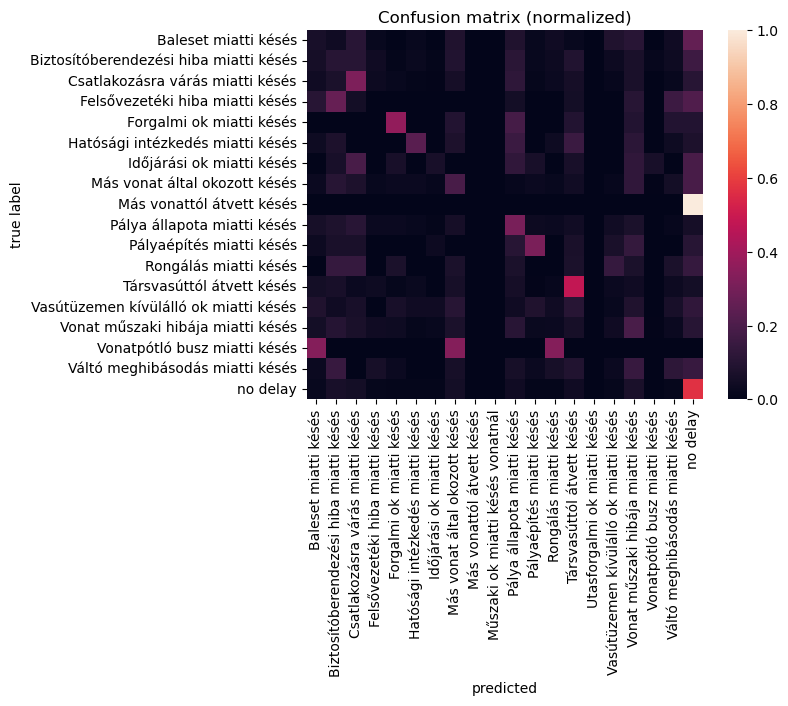

In [10]:
sns.heatmap(conf)
plt.ylabel('true label')
plt.xlabel('predicted')
plt.title('Confusion matrix (normalized)')
plt.show()